In [1]:
include("ExperimentDataDictionary.jl");
using Plots
pwd()

"/Users/nadanai263/OneDrive - University of Edinburgh/Coding/Repos/Research/CFPS-metabolic"

## Preliminary

In [2]:
# 1. Get experimental data

# Setup the timescale
TSTART = 0.0
TSTOP = 3.0
Ts = 0.1

# Read experimental data into dictionary (originally, 37 metabolite timeseries)
# Take experimental data and interpolate onto simulation timescale
experimental_data_dictionary = ExperimentDataDictionary(TSTART,TSTOP,Ts);

# dictionary links name of metabolite to a struct
# Experiment() has three elements: 
# model_index, interpolated_measurement_array, raw_measurement_array
dat1 = experimental_data_dictionary["CAT"].interpolated_measurement_array

31-element Array{Float64,1}:
 5.4445733e-5         
 0.0001524480500479445
 0.0009034502224604245
 0.0019804290075395754
 0.0034890270144881516
 0.0052134346         
 0.006171236279999999 
 0.007129037959999999 
 0.00808683964        
 0.00904464132        
 0.010002443          
 0.010336370899999999 
 0.0106702988         
 ⋮                    
 0.013007794100000001 
 0.013341722          
 0.013855271200000002 
 0.0143688204         
 0.0148823696         
 0.015395918799999998 
 0.015909468          
 0.0164230172         
 0.0169365664         
 0.0174501156         
 0.017963664799999998 
 0.018477214          

## Implementation: solve model

In [1]:
# 1. Load experimental data + model params into dictionary
include("DataFile.jl")
using Plots

TSTART = 0.0
TSTOP = 3.0
Ts = 0.1

# Create the data_dictionary and initialise it with network stoichiometric matrix, 
# experimental data, and all params to 0 (rates), 1 (initial conds, saturation, order),
# and 0.1 (gain).
data_dictionary = DataFile(TSTART,TSTOP,Ts)

# Import initial conditions
initial_condition_vector = vec(broadcast(abs, float(open(readdlm,"params/initial_condition.dat"))))
data_dictionary["INITIAL_CONDITION_ARRAY"] = initial_condition_vector

# Import best fit rate constants
rate_constant_vector = vec(broadcast(abs, float(open(readdlm,"params/rate_constant.dat"))))
data_dictionary["RATE_CONSTANT_ARRAY"] = rate_constant_vector

# Import best fit saturation constants
saturation_constant_array = broadcast(abs, float(open(readdlm,"params/saturation_constant.dat")))
data_dictionary["SATURATION_CONSTANT_ARRAY"] = saturation_constant_array

# Import best fit control parameters
control_constant_array = broadcast(abs, float(open(readdlm,"params/control_constant.dat")))
data_dictionary["CONTROL_PARAMETER_ARRAY"] = control_constant_array


# 2. Solve mass balance with initial conditions
include("MassBalances.jl")
using Sundials;

# Get required stuff from DataFile struct -
TSIM = (0.0,3.0) # tspan
initial_condition_vector = data_dictionary["INITIAL_CONDITION_ARRAY"];

# Use sundials to solve fluxes. MassBalances returns a vector of gradients
prob = ODEProblem(MassBalances,initial_condition_vector,TSIM,data_dictionary)
X = solve(prob,CVODE_BDF(),abstol=1e-9,reltol=1e-9)


# 3. Plot (Fig. 2 of Horvath 2020 paper)

p1 = plot(X, vars=(100))
p2 = plot(X, vars=(98))
p3 = plot(X, vars=(102))
p4 = plot(X, vars=(104))

p5 = plot(X, vars=(103))
p6 = plot(X, vars=(118))
p7 = plot(X, vars=(105))
p8 = plot()

plot(p1, p2, p3, p4, p5,p6,p7,p8, layout = (2,4), legend = false)

This is a kinetic model containing

* 352 species (enzymes, metabolites, TXTL)
* 204 reaction rate constants
* 204 enzymatic decay constnats
* 548 saturation constants
* 34 allosteric control parameters

which is trained on a dataset of 37 metabolite timeseries measurements over 3h.

To fit the parameters, a constrained MCMC method is used with the following bounds:

* TX/TL/mRNA deg: factor of 2 of reference 
* reaction rates: 1 order of magnitude of reference, determined as follows

-enzyme concentrations set to 170 nM; where available, kcat values multiplied with this gives the Vmax. 

Where not available, a geometric mean of Vmax=110mM/h was used, and rates bounded by 2 orders of magnitude.

* enzyme decay: 0 and 1/h == infty and 42 min
* saturation constant: 100 nM and 10 mM
* control gain: 0.05 and 10
* order params: 0.02 and 10

Cost function is sum squared errors.

Procedure: random walk, accept all with lower cost, accept higher cost sets with exponential probability.

*Implementation complete 2020-03-18*

## Project outline

**Aims**

1. Visualise network

2. Visualise rates, concentrations, and fluxes in intuitive way

2. Determine effect of variation of concentration of every enzyme (+/- 1 order of magnitude) on CAT production yield and lifetime; determine optimal enzymatic perturbations on system

3. Couple protein synthesis to enzymatic process

Kwatee installation notes:

* Java VM 8 already installed
* libsbml-5.18.0-libxml2-macosx-mojave to /usr/local 

## 1. Visualise network

In [4]:
using Plots
using DelimitedFiles

# The metabolism comes from the iAF1260 reconstruction 
# of K-12 MG1655 E. coli (Feist et al. 2007), with 
# growth associated reactions removed
# knocked-out reactions in host strain removed (speA, tnaA, sdaD, sdaB, gshA, tonA, endA)
# and added reactions for CAT biosynthesis, TX, and TL

# Load the stoichiometric matrix - 
S = float(open(readdlm,pwd()*"/network/Network.dat"));
size(S)

(352, 408)

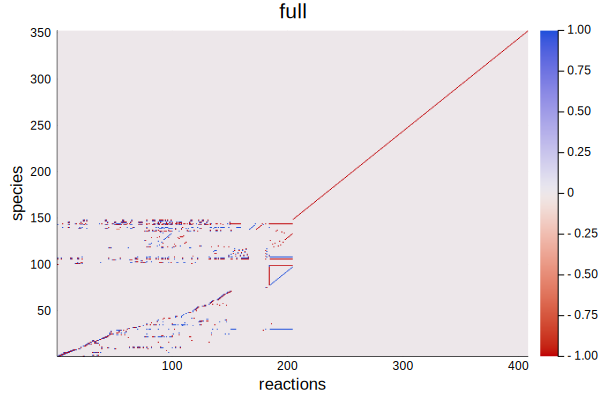

In [5]:
heatmap(S, color = :coolwarm_r, 
    xlabel="reactions", ylabel="species", title="full",
    clims=(-1, 1))

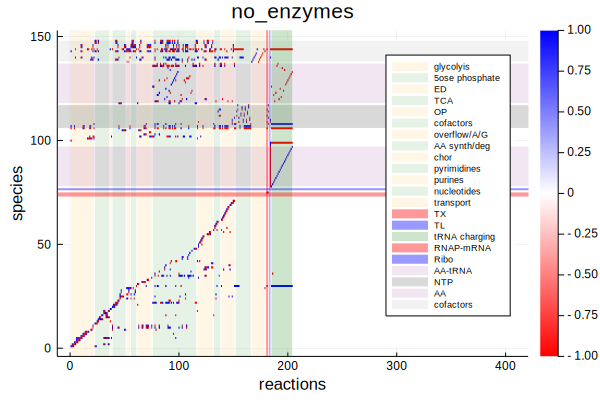

In [24]:
heatmap(S[1:148,:], color = ColorGradient([:red,:white,:blue]), 
    xlabel="reactions", ylabel="species", title="no_enzymes",
    clims=(-1, 1), legendfontsize=6)
vspan!([1, 22], fillcolor = :orange, alpha=0.1, label="glycolyis")
vspan!([23, 36], fillcolor = :green, alpha=0.1, label="5ose phosphate")
vspan!([37, 38], fillcolor = :orange, alpha=0.1, label="ED")
vspan!([39, 51], fillcolor = :green, alpha=0.1, label="TCA")
vspan!([52, 55], fillcolor = :orange, alpha=0.1, label="OP")
vspan!([56, 61], fillcolor = :green, alpha=0.1, label="cofactors")
vspan!([62, 75], fillcolor = :orange, alpha=0.1, label="overflow/A/G")
vspan!([76, 116], fillcolor = :green, alpha=0.1, label="AA synth/deg")
vspan!([117, 131], fillcolor = :orange, alpha=0.1, label="chor")
vspan!([132, 138], fillcolor = :green, alpha=0.1, label="pyrimidines")
vspan!([139, 151], fillcolor = :orange, alpha=0.1, label="purines")
vspan!([152, 166], fillcolor = :green, alpha=0.1, label="nucleotides")
vspan!([167, 179], fillcolor = :orange, alpha=0.1, label="transport")
vspan!([180, 182], fillcolor = :red, alpha=0.4, label="TX")
vspan!([183, 184], fillcolor = :blue, alpha=0.4, label="TL")
vspan!([185, 204], fillcolor = :green, alpha=0.2, label="tRNA charging")

hspan!([73,75], fillcolor = :red, alpha=0.4, label="RNAP-mRNA")
hspan!([76,77], fillcolor = :blue, alpha=0.4, label="Ribo")
hspan!([78, 97], fillcolor = :purple, alpha=0.1, label="AA-tRNA")
hspan!([106, 117], fillcolor = :grey, alpha=0.3, label="NTP")
hspan!([118, 137], fillcolor = :purple, alpha=0.1, label="AA")
hspan!([138, 148], fillcolor = :grey, alpha=0.1, label="cofactors")


#### Notes. 

Specific objectives:
* which metabolic enzymes can be most readily perturbed to extend protein synthesis yield and lifetime?

Given the best-fit set of parameters and initial conditions, we can calculate fluxes through the network. The set of fluxes consist of those constrained by experiment (37 species), the rest being inferred but underdetermined. Question: how general is this model? Given a variation in the initial conditions, is the model still useful to predict fluxes (in particular for some of the originally-constrained metabolites)? 

Given this particular instantiation of the network, we can definitely do a global sensitivity analysis for every reaction, to determine which reactions are most important in controlling protein synthesis.

## 2. Perturb network

### Preliminary

In [32]:
# 1. Load experimental data + model params into dictionary
include("DataFile.jl")
using Plots

TSTART = 0.0
TSTOP = 3.0
Ts = 0.1

# Create the data_dictionary and initialise it with network stoichiometric matrix, 
# experimental data, and all params to 0 (rates), 1 (initial conds, saturation, order),
# and 0.1 (gain).
data_dictionary = DataFile(TSTART,TSTOP,Ts)

# Import initial conditions
initial_condition_vector = vec(broadcast(abs, float(open(readdlm,"params/initial_condition.dat"))))
data_dictionary["INITIAL_CONDITION_ARRAY"] = initial_condition_vector

# Import best fit rate constants
rate_constant_vector = vec(broadcast(abs, float(open(readdlm,"params/rate_constant.dat"))))
data_dictionary["RATE_CONSTANT_ARRAY"] = rate_constant_vector

# Import best fit saturation constants
saturation_constant_array = broadcast(abs, float(open(readdlm,"params/saturation_constant.dat")))
data_dictionary["SATURATION_CONSTANT_ARRAY"] = saturation_constant_array

# Import best fit control parameters
control_constant_array = broadcast(abs, float(open(readdlm,"params/control_constant.dat")))
data_dictionary["CONTROL_PARAMETER_ARRAY"] = control_constant_array


17×2 Array{Float64,2}:
 7.54512     5.13817  
 0.02        0.05     
 1.9291      0.751356 
 0.02        7.4953   
 4.63374    10.0      
 0.592884    0.935962 
 9.37074     0.05     
 0.02        0.123142 
 0.801429    0.125475 
 0.02        0.05     
 0.814314    0.102612 
 3.25384     1.39682  
 0.0316173   0.050444 
 1.73282     9.58861  
 0.929944    1.97639  
 0.0357943   2.78689  
 8.46437     0.0797687

In [33]:
# 2. Solve mass balance with initial conditions
include("MassBalances.jl")
using Sundials;


In [51]:
# Test script in this cell

TSTART = 0.0
TSTOP = 3.0
Ts = 0.1

# Create the data_dictionary and initialise it with network stoichiometric matrix, 
# experimental data, and all params to 0 (rates), 1 (initial conds, saturation, order),
# and 0.1 (gain).
data_dictionary = DataFile(TSTART,TSTOP,Ts)

# Import initial conditions
initial_condition_vector = vec(broadcast(abs, float(open(readdlm,"params/initial_condition.dat"))))
data_dictionary["INITIAL_CONDITION_ARRAY"] = initial_condition_vector

# Import best fit rate constants
rate_constant_vector = vec(broadcast(abs, float(open(readdlm,"params/rate_constant.dat"))))
data_dictionary["RATE_CONSTANT_ARRAY"] = rate_constant_vector

# Import best fit saturation constants
saturation_constant_array = broadcast(abs, float(open(readdlm,"params/saturation_constant.dat")))
data_dictionary["SATURATION_CONSTANT_ARRAY"] = saturation_constant_array

# Import best fit control parameters
control_constant_array = broadcast(abs, float(open(readdlm,"params/control_constant.dat")))
data_dictionary["CONTROL_PARAMETER_ARRAY"] = control_constant_array


#--------------------PERTURBATION HERE--------------------
#152 id:E_R_pfk symbol:E_R_pfk
data_dictionary["INITIAL_CONDITION_ARRAY"][152] == 1.0
#---------------------------------------------------------

# Get required stuff from DataFile struct -
TSIM = (0.0,3.0) # tspan
initial_condition_vector = data_dictionary["INITIAL_CONDITION_ARRAY"];

# Use sundials to solve fluxes. MassBalances returns a vector of gradients
prob = ODEProblem(MassBalances,initial_condition_vector,TSIM,data_dictionary)
X = solve(prob,CVODE_BDF(),abstol=1e-9,reltol=1e-9)


# 3. Plot (Fig. 2 of Horvath 2020 paper)

p1 = plot(X, vars=(100), label="glucose")
p2 = plot(X, vars=(75), label="mRNA_CAT")
p3 = plot(X, vars=(98), label="CAT")
p4 = plot(X, vars=(152), label="PFK")
p5 = plot(X, vars=(2), label="f6p")
p6 = plot(X, vars=(3), label="fdp")
p7 = plot(X, vars=(106), label="atp")
p8 = plot(X, vars=(107), label="adp")


plot(p1, p2, p3, p4, p5, p6, p7, p8,  layout = (2,4), legend = false)

### Run experiment

In [1]:
include("DataFile.jl")
include("MassBalances.jl")
using Sundials;
using ProgressBars;

# Define solver function

function RunSim(enzymeIndex,value)
    
TSTART = 0.0
TSTOP = 3.0
Ts = 0.1

# Create the data_dictionary and initialise it with network stoichiometric matrix, 
# experimental data, and all params to 0 (rates), 1 (initial conds, saturation, order),
# and 0.1 (gain).
data_dictionary = DataFile(TSTART,TSTOP,Ts)

# Import initial conditions
initial_condition_vector = vec(broadcast(abs, float(open(readdlm,"params/initial_condition.dat"))))
data_dictionary["INITIAL_CONDITION_ARRAY"] = initial_condition_vector

# Import best fit rate constants
rate_constant_vector = vec(broadcast(abs, float(open(readdlm,"params/rate_constant.dat"))))
data_dictionary["RATE_CONSTANT_ARRAY"] = rate_constant_vector

# Import best fit saturation constants
saturation_constant_array = broadcast(abs, float(open(readdlm,"params/saturation_constant.dat")))
data_dictionary["SATURATION_CONSTANT_ARRAY"] = saturation_constant_array

# Import best fit control parameters
control_constant_array = broadcast(abs, float(open(readdlm,"params/control_constant.dat")))
data_dictionary["CONTROL_PARAMETER_ARRAY"] = control_constant_array

#--------------------PERTURBATION HERE--------------------
data_dictionary["INITIAL_CONDITION_ARRAY"][enzymeIndex] = value
#---------------------------------------------------------

# Get required stuff from DataFile struct -
TSIM = (0.0,3.0) # tspan
initial_condition_vector = data_dictionary["INITIAL_CONDITION_ARRAY"];

# Use sundials to solve fluxes. MassBalances returns a vector of gradients
prob = ODEProblem(MassBalances,initial_condition_vector,TSIM,data_dictionary)
X = solve(prob,CVODE_BDF(),abstol=1e-9,reltol=1e-9)
    
return(X)
end

RunSim (generic function with 1 method)

In [2]:
# Run model: iterate over all enzymes and write output
# To read: sol = readdlm("./OUT/X")

for j in ProgressBar(149:352)

    X = RunSim(j,10.0)   
    writedlm("./OUT/"*string(j)*"Xt_up",X.t)
    writedlm("./OUT/"*string(j)*"Xu_up",X.u)
    
    X = RunSim(j,0.1)   
    writedlm("./OUT/"*string(j)*"Xt_dwn",X.t)
    writedlm("./OUT/"*string(j)*"Xu_dwn",X.u)
    
end

100.0%┣█████████████████████████████████████████████████████████┫ 204/204 [01:08:07<00:00, 0.0 it/s]


In [2]:
# Analyse output

enzymeIndex = [];
CATfinal_up = [];
CATfinal_dwn = [];

for j in ProgressBar(149:352)
    
    sol = readdlm("./OUT/"*string(j)*"Xu_up");
    sz = size(sol)[1]
    push!(enzymeIndex,j);
    push!(CATfinal_up, sol[sz,98]); # read final CAT level (at 3h)
    
    sol = readdlm("./OUT/"*string(j)*"Xu_dwn");
    sz = size(sol)[1]
    push!(CATfinal_dwn, sol[sz,98]); # read final CAT level (at 3h)
    
end

100.0%┣████████████████████████████████████████████████████████████┫ 204/204 [04:29<00:00, 0.8 it/s]


In [13]:
using Plots

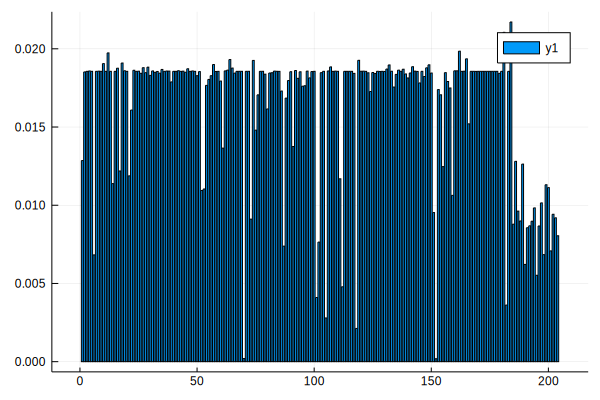

In [14]:
Plots.bar(CATfinal_up)

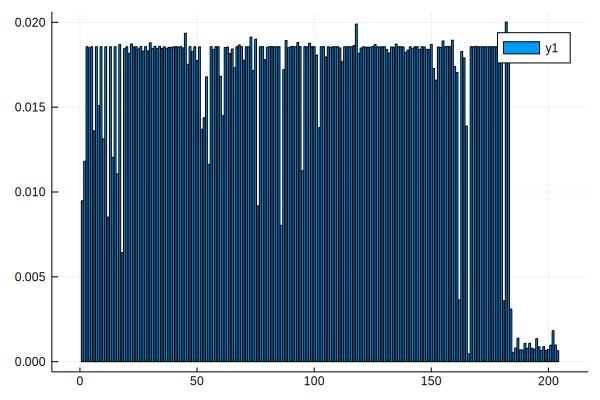

In [15]:
Plots.bar(CATfinal_dwn)

In [3]:
upsortidx = sortperm(CATfinal_up, rev=true);
dwnsortidx = sortperm(CATfinal_dwn, rev=true);

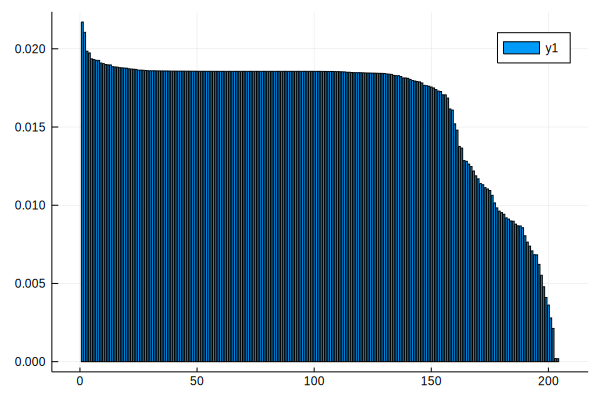

In [24]:
Plots.bar(CATfinal_up[upsortidx])

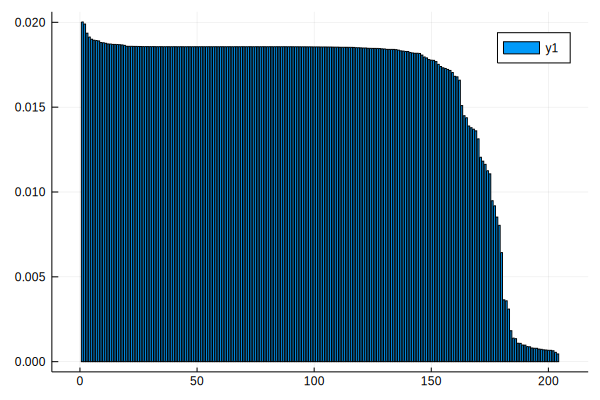

In [25]:
Plots.bar(CATfinal_dwn[dwnsortidx])

In [4]:
# Top 25 and bottom 25
up1 = upsortidx[1:8];
up2 = upsortidx[197:204];
dwn1 = dwnsortidx[1:8];
dwn2 = dwnsortidx[197:204];

upidx = vcat(up1,up2);
dwnidx = vcat(dwn1,dwn2);
idx2d = vcat(upidx,dwnidx);

In [18]:
include("DataFile.jl")
include("MassBalances.jl")
using Sundials;
using ProgressBars;

# Define solver function

function RunSim2D(idx1,idx2,val1,val2)
    
TSTART = 0.0
TSTOP = 3.0
Ts = 0.1

# Create the data_dictionary and initialise it with network stoichiometric matrix, 
# experimental data, and all params to 0 (rates), 1 (initial conds, saturation, order),
# and 0.1 (gain).
data_dictionary = DataFile(TSTART,TSTOP,Ts)

# Import initial conditions
initial_condition_vector = vec(broadcast(abs, float(open(readdlm,"params/initial_condition.dat"))))
data_dictionary["INITIAL_CONDITION_ARRAY"] = initial_condition_vector

# Import best fit rate constants
rate_constant_vector = vec(broadcast(abs, float(open(readdlm,"params/rate_constant.dat"))))
data_dictionary["RATE_CONSTANT_ARRAY"] = rate_constant_vector

# Import best fit saturation constants
saturation_constant_array = broadcast(abs, float(open(readdlm,"params/saturation_constant.dat")))
data_dictionary["SATURATION_CONSTANT_ARRAY"] = saturation_constant_array

# Import best fit control parameters
control_constant_array = broadcast(abs, float(open(readdlm,"params/control_constant.dat")))
data_dictionary["CONTROL_PARAMETER_ARRAY"] = control_constant_array

#--------------------PERTURBATION HERE--------------------
data_dictionary["INITIAL_CONDITION_ARRAY"][idx1] = val1;
data_dictionary["INITIAL_CONDITION_ARRAY"][idx2] = val2;
#---------------------------------------------------------

# Get required stuff from DataFile struct -
TSIM = (0.0,3.0) # tspan
initial_condition_vector = data_dictionary["INITIAL_CONDITION_ARRAY"];

# Use sundials to solve fluxes. MassBalances returns a vector of gradients
prob = ODEProblem(MassBalances,initial_condition_vector,TSIM,data_dictionary)
X = solve(prob,CVODE_BDF(),abstol=1e-9,reltol=1e-9)
    
return(X)
end

RunSim2D (generic function with 1 method)

In [19]:
# 2D search

DIR = "/Volumes/NL Backup 1/OUT2D"

# Run model: iterate over all enzymes and write output
# To read: sol = readdlm("./OUT/X")

for j in ProgressBar(idx2d[8:32])

    for k in ProgressBar(idx2d)
        
        X = RunSim2D(j,k,10.0,10.0)   
        writedlm(DIR*"/upup/"*string(j)*'_'*string(k)*"Xt",X.t)
        writedlm(DIR*"/upup/"*string(j)*'_'*string(k)*"Xu",X.u)
        
        X = RunSim2D(j,k,10.0,0.1)   
        writedlm(DIR*"/updwn/"*string(j)*'_'*string(k)*"Xt",X.t)
        writedlm(DIR*"/updwn/"*string(j)*'_'*string(k)*"Xu",X.u)
        
        X = RunSim2D(j,k,0.1,10.0)   
        writedlm(DIR*"/dwnup/"*string(j)*'_'*string(k)*"Xt",X.t)
        writedlm(DIR*"/dwnup/"*string(j)*'_'*string(k)*"Xu",X.u)

        X = RunSim2D(j,k,0.1,0.1)   
        writedlm(DIR*"/dwndwn/"*string(j)*'_'*string(k)*"Xt",X.t)
        writedlm(DIR*"/dwndwn/"*string(j)*'_'*string(k)*"Xu",X.u)
    
    end
end

100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [25:48<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [21:41<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [21:50<00:00, 0.0 it/s]
37.5%┣███████████████████████▋                                       ┫ 12/32 [07:39<13:54, 0.0 it/s]


[CVODES ERROR]  CVode
  At t = 1.74886 and h = 2.53887e-07, the error test failed repeatedly or with |h| = hmin.



53.1%┣█████████████████████████████████▌                             ┫ 17/32 [10:39<09:59, 0.0 it/s]


[CVODES ERROR]  CVode
  At t = 1.74886 and h = 2.53887e-07, the error test failed repeatedly or with |h| = hmin.



100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [20:14<00:00, 0.0 it/s]
34.4%┣█████████████████████▋                                         ┫ 11/32 [07:41<16:08, 0.0 it/s]


[CVODES ERROR]  CVode
  At t = 1.74886 and h = 2.53887e-07, the error test failed repeatedly or with |h| = hmin.



100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [22:31<00:00, 0.0 it/s]
0.0%┣                                                               ┫ 0/32 [00:00<00:-2, -20.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.78613 and h = 4.05453e-07, the error test failed repeatedly or with |h| = hmin.



100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [21:32<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:14<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:35<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:44<00:00, 0.0 it/s]
34.4%┣█████████████████████▋                                         ┫ 11/32 [06:25<13:29, 0.0 it/s]


[CVODES ERROR]  CVode
  At t = 1.74886 and h = 2.53887e-07, the error test failed repeatedly or with |h| = hmin.



100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:12<00:00, 0.0 it/s]
0.0%┣                                                               ┫ 0/32 [00:00<00:-2, -20.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.78613 and h = 4.05453e-07, the error test failed repeatedly or with |h| = hmin.



100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [20:12<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:05<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [20:44<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:55<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [18:56<00:00, 0.0 it/s]
0.0%┣                                                               ┫ 0/32 [00:00<00:-2, -20.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.80588 and h = 4.32819e-07, the error test failed repeatedly or with |h| = hmin.



100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:20<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:02<00:00, 0.0 it/s]
0.0%┣                                                               ┫ 0/32 [00:00<00:-2, -20.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.86764 and h = 4.1415e-07, the error test failed repeatedly or with |h| = hmin.



100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [17:48<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:41<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [20:05<00:00, 0.0 it/s]
0.0%┣                                                               ┫ 0/32 [00:00<00:-2, -20.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.86613 and h = 5.88576e-07, the error test failed repeatedly or with |h| = hmin.



100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [18:57<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:03<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [20:00<00:00, 0.0 it/s]
100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [19:26<00:00, 0.0 it/s]
37.5%┣███████████████████████▋                                       ┫ 12/32 [07:32<13:42, 0.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.78613 and h = 4.05453e-07, the error test failed repeatedly or with |h| = hmin.



53.1%┣█████████████████████████████████▌                             ┫ 17/32 [10:38<09:58, 0.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.78613 and h = 4.05453e-07, the error test failed repeatedly or with |h| = hmin.



68.8%┣███████████████████████████████████████████▎                   ┫ 22/32 [13:47<06:34, 0.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.80588 and h = 4.32819e-07, the error test failed repeatedly or with |h| = hmin.



75.0%┣███████████████████████████████████████████████▎               ┫ 24/32 [15:07<05:15, 0.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.86764 and h = 4.1415e-07, the error test failed repeatedly or with |h| = hmin.



84.4%┣█████████████████████████████████████████████████████▏         ┫ 27/32 [16:59<03:16, 0.0 it/s]


[CVODES ERROR]  CVode
  At t = 2.86613 and h = 5.88576e-07, the error test failed repeatedly or with |h| = hmin.



100.0%┣██████████████████████████████████████████████████████████████┫ 32/32 [20:07<00:00, 0.0 it/s]
100.0%┣███████████████████████████████████████████████████████████┫ 25/25 [08:23:42<00:00, 0.0 it/s]


In [15]:
# 1st run: j 1:7

idx2d[8:32]

25-element Array{Int64,1}:
  74
 195
 112
 101
 182
 105
 118
  70
 152
 182
 118
  45
  73
  75
 159
  88
 155
 200
 188
 189
 197
 199
 204
 185
 166